In [1]:
import tensorflow as tf
import pickle, os, sys, time
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from utils.MyRAN92_v1 import ResidualAttentionModel_92
from contextlib import redirect_stdout

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
print(gpus)

1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
path = './models'
model_name = '/ran92_v1'
model_path = path + model_name
if not os.path.exists(model_path):
    os.makedirs(model_path)
    print(model_path)
else:
    print(model_path + ' already exists.')

history_path = model_path + '/history'
if not os.path.exists(history_path):
    os.makedirs(history_path)
    print(history_path)
else:
    print(history_path + ' already exists.')

saved_model_path = model_path + '/saved_models'
if not os.path.exists(saved_model_path):
    os.makedirs(saved_model_path)
    print(saved_model_path)
else:
    print(saved_model_path + ' already exists.')
    
checkpoint_path = history_path + "/checkpoints"
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    print(checkpoint_path + ' already exists.')
    
graph_path = model_path + '/graphs'
if not os.path.exists(graph_path):
    os.makedirs(graph_path)
    print(graph_path)
else:
    print(graph_path + ' already exists.')

./models/ran92_v1 already exists.
./models/ran92_v1/history already exists.
./models/ran92_v1/saved_models already exists.
./models/ran92_v1/history/checkpoints already exists.
./models/ran92_v1/graphs already exists.


In [4]:
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                          width_shift_range=0.2,
                                                          height_shift_range=0.2,
                                                          horizontal_flip=True,
                                                          validation_split=0.2)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = X_train - X_train.mean()
X_test = X_test - X_test.mean()

datagen.fit(X_train)

input_shape = X_train.shape[1:]
output_classes = 10

In [6]:
ran92 = ResidualAttentionModel_92(input_shape, output_classes, use_bias=True)

model = ran92.return_Model()

model.compile(tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Model_Input (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1_In (Conv2D)              (None, 32, 32, 32)   896         ['Model_Input[0][0]']            
                                                                                                  
 BN_In (BatchNormalization)     (None, 32, 32, 32)   128         ['Conv1_In[0][0]']               
                                                                                                  
 ReLU_In (Activation)           (None, 32, 32, 32)   0           ['BN_In[0][0]']                  
                                                                                              

In [7]:
global summary_filename 
summary_filename = graph_path + '/{}'.format(model_name[1:]) + '_modelsummary.txt'
print(summary_filename)

./models/ran92_v1/graphs/ran92_v1_modelsummary.txt


In [8]:
with open(summary_filename, 'w') as f:
    with redirect_stdout(f):
        model.summary()

In [9]:
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    print(checkpoint_path + ' already exists.')

./models/ran92_v1/history/checkpoints already exists.


In [28]:
checkpoint_path_ckpt = checkpoint_path + '/' + time.ctime().replace(':','_').replace(' ', '_') + '/cp-{epoch}.ckpt'
print(checkpoint_path_ckpt)

./models/ran92_v1/history/checkpoints/Mon_Dec_20_18_22_01_2021/cp-{epoch}.ckpt


In [11]:
print(checkpoint_path, '\n', checkpoint_path_ckpt )
# checkpoint_dir = os.path.dirname(checkpoint_path_ckpt)
# print(checkpoint_dir)

./models/ran92_v1/history/checkpoints 
 ./models/ran92_v1/history/checkpoints/Mon_Dec_20_18_12_29_2021/cp-{epoch}.ckpt


In [11]:
checkpoint_path_ckpt = "./models/ran92_v1/history/checkpoints/Mon_Dec_20_14_04_26_2021"
checkpoint_path_ckpt

'./models/ran92_v1/history/checkpoints/Mon_Dec_20_14_04_26_2021'

In [26]:
from sklearn.metrics import accuracy_score

In [30]:
train_loss = []
val_loss = []

train_acc = []
val_acc= []

loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Since we lost the actual training history, approximating the history here by sampling 1024 and only doing one batch so it doesn't take too long
for e in range(1, 201):
    checkpoint = f"{checkpoint_path_ckpt}/cp-{e}.ckpt"

    model.load_weights(checkpoint)
    print(f"Loaded model at ckpt {e}")
    epoch_train_loss = 0.0
    epoch_train_acc = 0.0
    for x_in, y_true in datagen.flow(X_train, y_train, batch_size=1024, subset='training'):
        preds = model.predict(x_in)
        loss_out = loss_fn(preds, y_true).numpy()

        y_true = np.argmax(y_true, axis=1)
        preds = np.argmax(preds, axis=1)
        acc = accuracy_score(y_true, preds)

        epoch_train_loss = (epoch_train_loss + loss_out) / 2
        epoch_train_acc = (epoch_train_acc + acc) / 2

        break 

    epoch_val_loss = 0.0
    epoch_val_acc = 0.0
    for x_in, y_true in datagen.flow(X_train, y_train, batch_size=1024, subset='validation'):
        preds = model.predict(x_in)
        loss_out = loss_fn(preds, y_true).numpy()

        y_true = np.argmax(y_true, axis=1)
        preds = np.argmax(preds, axis=1)
        acc = accuracy_score(y_true, preds)

        epoch_val_loss = (epoch_val_loss + loss_out) / 2
        epoch_val_acc = (epoch_val_acc + acc) / 2

        break

    print(f"Training: Loss {epoch_train_loss} Acc {epoch_train_acc} Validation: Loss {epoch_val_loss} Acc {epoch_val_acc}")
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

Loaded model at ckpt 1
Training: Loss 6.384653568267822 Acc 0.13134765625 Validation: Loss 6.28959321975708 Acc 0.1435546875
Loaded model at ckpt 2
Training: Loss 6.117345809936523 Acc 0.142578125 Validation: Loss 6.119327068328857 Acc 0.1396484375
Loaded model at ckpt 3
Training: Loss 5.66281270980835 Acc 0.1875 Validation: Loss 5.847397804260254 Acc 0.17041015625
Loaded model at ckpt 4
Training: Loss 5.582086563110352 Acc 0.1865234375 Validation: Loss 5.719259738922119 Acc 0.17431640625
Loaded model at ckpt 5
Training: Loss 5.904263973236084 Acc 0.1513671875 Validation: Loss 6.035119533538818 Acc 0.14599609375
Loaded model at ckpt 6
Training: Loss 5.803184986114502 Acc 0.15869140625 Validation: Loss 5.722105979919434 Acc 0.16650390625
Loaded model at ckpt 7
Training: Loss 5.446336269378662 Acc 0.17724609375 Validation: Loss 5.460632801055908 Acc 0.18701171875
Loaded model at ckpt 8
Training: Loss 4.795383453369141 Acc 0.26123046875 Validation: Loss 4.963116645812988 Acc 0.244140625
L

In [31]:
save_pth = "models/ran92_v1/history"
np.save("ran92_v1_train_loss_history.npy", train_loss)
np.save("ran92_v1_train_acc_history.npy", train_acc)
np.save("ran92_v1_val_loss_history.npy", val_loss)
np.save("ran92_v1_val_acc_history.npy", val_acc)


In [33]:
plot_loss_filename = graph_path + '/ran92_v1_Loss.png'
print(plot_loss_filename)
plot_acc_filename = graph_path + '/ran92_v1_Accuracy.png'
print(plot_acc_filename)

./models/ran92_v1/graphs/ran92_v1_Loss.png
./models/ran92_v1/graphs/ran92_v1_Accuracy.png


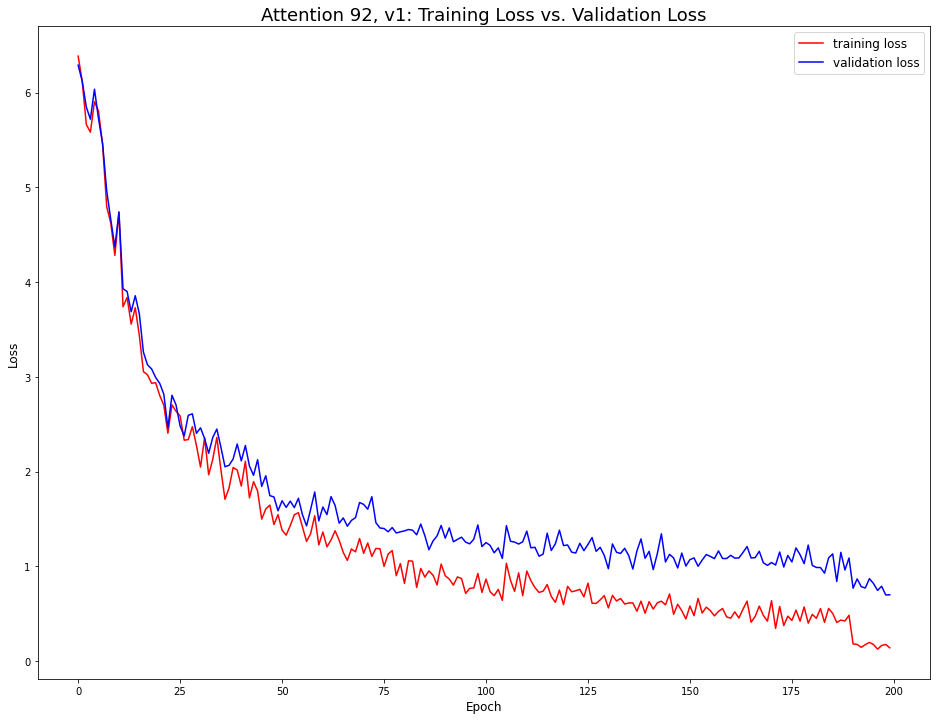

In [35]:
plt.figure(figsize=(16,12))
plt.title("Attention 92, v1: Training Loss vs. Validation Loss", fontsize=18)
plt.plot(train_loss, label='training loss', color='red')
plt.plot(val_loss, label = 'validation loss', color='blue')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.savefig(plot_loss_filename)
plt.show()

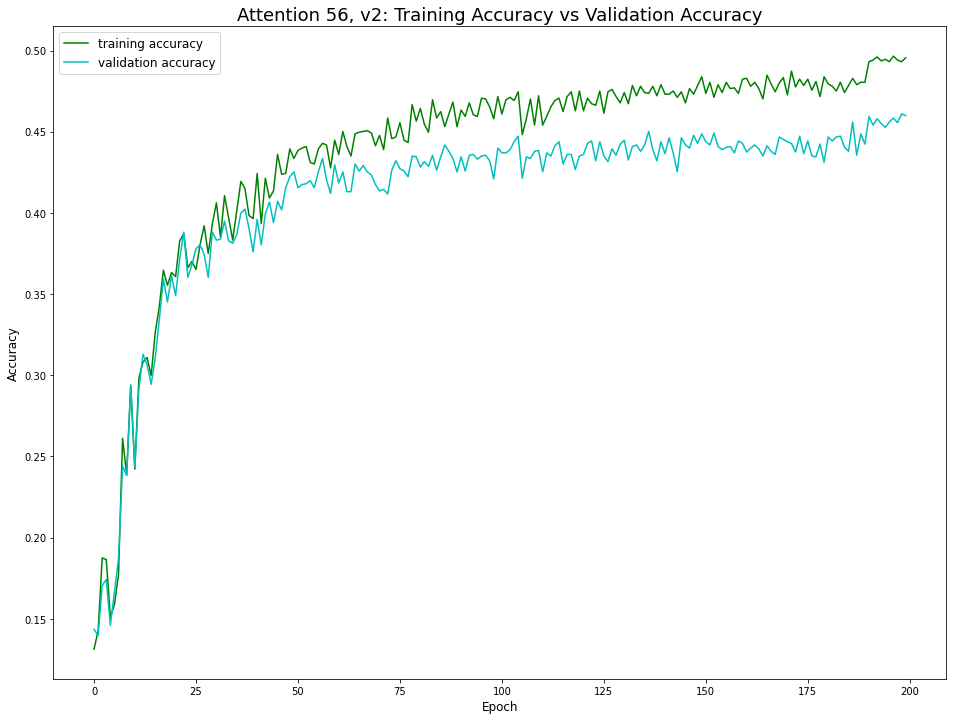

In [36]:
plt.figure(figsize=(16,12))
plt.title("Attention 56, v2: Training Accuracy vs Validation Accuracy", fontsize=18)
plt.plot(train_acc, label='training accuracy', color='g')
plt.plot(val_acc, label = 'validation accuracy', color='c')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.savefig(plot_acc_filename)
plt.show()